<a href="https://colab.research.google.com/github/elhamkashi/DSPS_EKashi/blob/main/HW5/poblem_2_of_hogg_and_foreman_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

Acceptance rate: 0.785


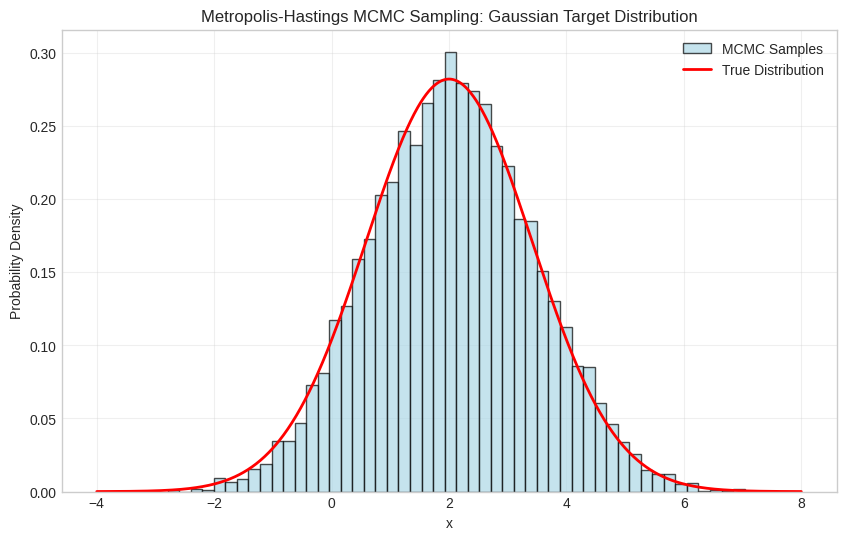

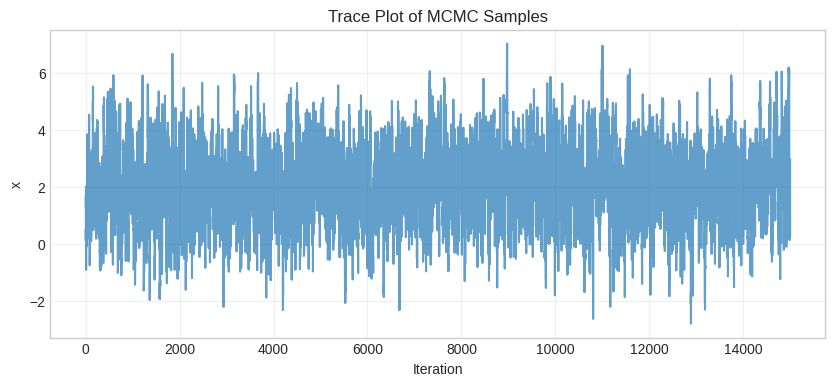

Sample mean: 2.055 (True: 2.000)
Sample variance: 1.967 (True: 2.000)
First 10 samples: [0.49671415 0.35844985 0.12429648 0.12429648 1.70350929 1.70350929
 1.23403491 1.77659495 2.01855722 0.10527698]


In [22]:


# Set random seed for reproducibility
np.random.seed(42)

def target_distribution(x):
    """Target distribution: Gaussian with mean=2, variance=2"""
    return stats.norm.pdf(x, loc=2, scale=np.sqrt(2))

def proposal_distribution(current_x):
    """Proposal distribution: Gaussian centered at current_x with variance=1"""
    return np.random.normal(loc=current_x, scale=1)

def metropolis_hastings(n_samples):
    """Metropolis-Hastings MCMC sampler"""
    # Initialize
    x_current = 0.0
    samples = np.zeros(n_samples)
    accepted = 0

    for i in range(n_samples):
        # Generate proposal
        x_proposed = proposal_distribution(x_current)

        # Calculate acceptance ratio
        acceptance_ratio = (target_distribution(x_proposed) /
                          target_distribution(x_current))

        # Accept or reject
        if np.random.uniform(0, 1) < acceptance_ratio:
            x_current = x_proposed
            accepted += 1

        samples[i] = x_current

    acceptance_rate = accepted / n_samples
    return samples, acceptance_rate

# Run MCMC sampler
n_samples = 15000
samples, acceptance_rate = metropolis_hastings(n_samples)

print(f"Acceptance rate: {acceptance_rate:.3f}")

# Plot results
plt.figure(figsize=(10, 6))

# Plot histogram of samples
plt.hist(samples, bins=50, density=True, alpha=0.7,
         label='MCMC Samples', color='lightblue', edgecolor='black')

# Plot true distribution
x_range = np.linspace(-4, 8, 1000)
true_dist = target_distribution(x_range)
plt.plot(x_range, true_dist, 'r-', linewidth=2, label='True Distribution')

plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Metropolis-Hastings MCMC Sampling: Gaussian Target Distribution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot trace plot to check convergence
plt.figure(figsize=(10, 4))
plt.plot(samples, alpha=0.7)
plt.xlabel('Iteration')
plt.ylabel('x')
plt.title('Trace Plot of MCMC Samples')
plt.grid(True, alpha=0.3)
plt.show()

# Print some statistics
print(f"Sample mean: {np.mean(samples):.3f} (True: 2.000)")
print(f"Sample variance: {np.var(samples):.3f} (True: 2.000)")
print(f"First 10 samples: {samples[:10]}")

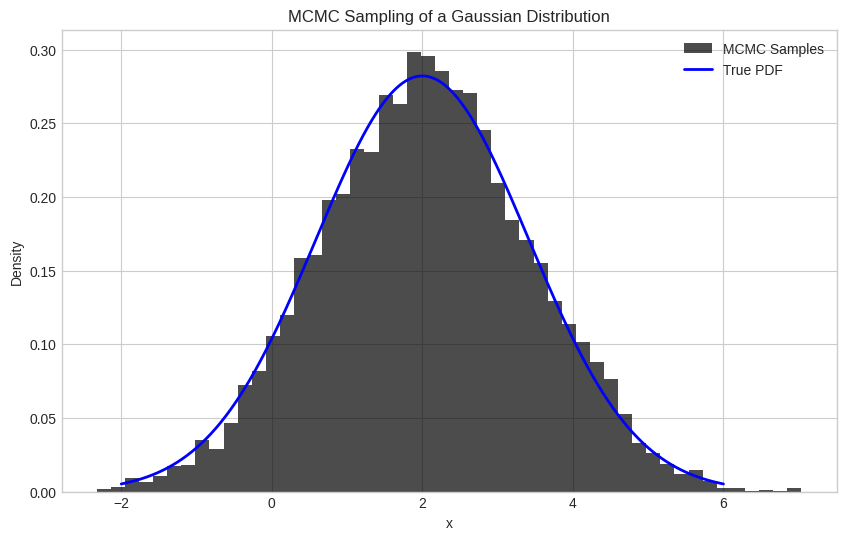

Sample mean: 2.049
Sample std: 1.389
True mean: 2.000
True std: 1.414


In [23]:


# Set random seed for reproducibility
np.random.seed(42)

# Define the target distribution: Gaussian with mean 2 and variance 2
def target_distribution(x):
    mean = 2.0
    variance = 2.0
    return np.exp(-0.5 * (x - mean)**2 / variance) / np.sqrt(2 * np.pi * variance)

# Metropolis-Hastings MCMC sampler
def metropolis_hastings_mcmc(n_steps, initial_position, proposal_sd):
    samples = []
    current_position = initial_position

    for i in range(n_steps):
        # Propose a new position
        proposed_position = current_position + np.random.normal(0, proposal_sd)

        # Compute acceptance ratio
        current_prob = target_distribution(current_position)
        proposed_prob = target_distribution(proposed_position)
        acceptance_ratio = proposed_prob / current_prob

        # Accept or reject
        if np.random.rand() < acceptance_ratio:
            current_position = proposed_position

        samples.append(current_position)

    return np.array(samples)

# Parameters
n_steps = 10000
initial_position = 0.0
proposal_sd = 1.0  # standard deviation of proposal distribution

# Run MCMC
samples = metropolis_hastings_mcmc(n_steps, initial_position, proposal_sd)

# Plot results
plt.figure(figsize=(10, 6))
plt.hist(samples, bins=50, density=True, alpha=0.7, color='black', label='MCMC Samples')

# Plot true distribution
x_vals = np.linspace(-2, 6, 1000)
true_pdf = target_distribution(x_vals)
plt.plot(x_vals, true_pdf, 'b-', linewidth=2, label='True PDF')

plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.title('MCMC Sampling of a Gaussian Distribution')
plt.show()

# Print some basic statistics
print(f"Sample mean: {np.mean(samples):.3f}")
print(f"Sample std: {np.std(samples):.3f}")
print(f"True mean: 2.000")
print(f"True std: {np.sqrt(2):.3f}")

# Problem 2 — Minimal Metropolis–Hastings (Hogg & Foreman-Mackey, 2017)

**Goal:** Implement a tiny Metropolis–Hastings (M–H) sampler for a 1D Gaussian target  
$ p(x) = \mathcal{N}(\mu=2,\ \sigma^2=2) $ using a Gaussian proposal  
$ q(x'|x)=\mathcal{N}(x,\ 1) $, starting at $x_0=0$.  
Run many steps, then plot a histogram of the samples and overlay the true density.


In [24]:


# Reproducible random generator
rng = np.random.default_rng(42)

# (Optional) nicer plots
plt.rcParams["figure.figsize"] = (12, 7)
plt.rcParams["axes.grid"] = True


In [25]:
# Target: Normal(mu=2, var=2)
mu = 2.0
var = 2.0
sigma = np.sqrt(var)

def logpdf_target(x):
    """Log-density of N(mu=2, var=2); works on scalars or arrays."""
    return -0.5*np.log(2*np.pi*var) - 0.5*((x - mu)**2)/var

# Quick sanity check
print("log p(mu) =", float(logpdf_target(mu)))


log p(mu) = -1.2655121234846454


In [26]:
def metropolis(logpdf, x0, steps=50_000, prop_sigma=1.0, rng=None):
    """
    Minimal Metropolis sampler with a symmetric Gaussian proposal:
    x' ~ N(x, prop_sigma^2).
    Accept if log u < [log p(x') - log p(x)], with u ~ Uniform(0,1).
    """
    if rng is None:
        rng = np.random.default_rng()

    samples = np.empty(steps, dtype=float)
    x = float(x0)
    accepted = 0

    for i in range(steps):
        x_prop = rng.normal(loc=x, scale=prop_sigma)
        loga = logpdf(x_prop) - logpdf(x)  # symmetric proposal → Hastings ratio cancels
        if np.log(rng.random()) < loga:
            x = x_prop
            accepted += 1
        samples[i] = x

    return samples, accepted/steps


In [27]:
steps = 50_000
x0 = 0.0
prop_sigma = 1.0

samples, acc_rate = metropolis(logpdf_target, x0, steps=steps, prop_sigma=prop_sigma, rng=rng)

burn = 1_000
chain = samples
post = samples[burn:]  # drop burn-in

print(f"Acceptance rate ≈ {acc_rate:.3f}")
print(f"Posterior mean ≈ {np.mean(post):.3f}  (true μ = {mu})")
print(f"Posterior variance ≈ {np.var(post, ddof=1):.3f}  (true σ² = {var})")


Acceptance rate ≈ 0.782
Posterior mean ≈ 1.997  (true μ = 2.0)
Posterior variance ≈ 2.075  (true σ² = 2.0)


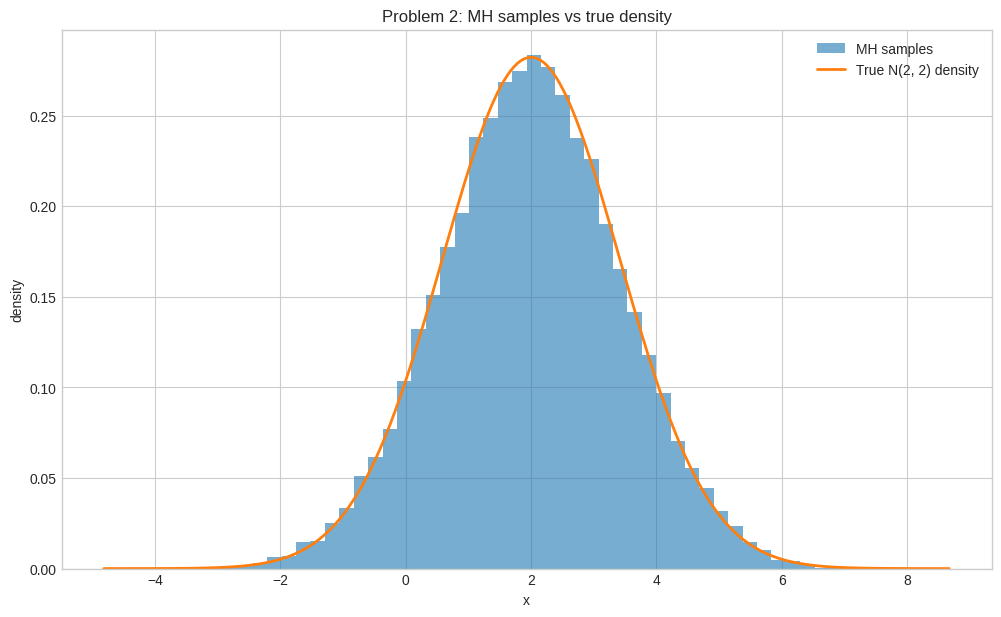

In [28]:
fig = plt.figure()
_ = plt.hist(post, bins=50, density=True, alpha=0.6, label="MH samples")

xgrid = np.linspace(min(-3, post.min()-1), max(7, post.max()+1), 500)
true_pdf = (1/(np.sqrt(2*np.pi*var))) * np.exp(-0.5*((xgrid-mu)**2)/var)
_ = plt.plot(xgrid, true_pdf, linewidth=2, label="True N(2, 2) density")

_ = plt.title("Problem 2: MH samples vs true density")
_ = plt.xlabel("x")
_ = plt.ylabel("density")
_ = plt.legend()
plt.show()


In [29]:
# ===== IMPORTS =====
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Set random seed for reproducibility
np.random.seed(42)

# Better plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [30]:
# ===== TARGET DISTRIBUTION DEFINITION =====
# Problem 2 specifies: p(x) = N(μ=2, σ²=2)
mu_true = 2.0
var_true = 2.0
sigma_true = np.sqrt(var_true)

def log_target(x):
    """Log-density of target distribution: Normal(2, 2)"""
    return -0.5 * np.log(2 * np.pi * var_true) - 0.5 * (x - mu_true)**2 / var_true

def target_pdf(x):
    """PDF of target distribution for plotting"""
    return norm.pdf(x, mu_true, sigma_true)

# Quick verification
print(f"Target: N(μ={mu_true}, σ²={var_true})")
print(f"p(μ) = {target_pdf(mu_true):.4f}")

Target: N(μ=2.0, σ²=2.0)
p(μ) = 0.2821


In [31]:
# ===== METROPOLIS-HASTINGS SAMPLER =====
def metropolis_sampler(log_density, x0, n_steps=10000, proposal_std=1.0):
    """
    Basic Metropolis-Hastings MCMC sampler with Gaussian proposal.

    Parameters:
    - log_density: function returning log(p(x))
    - x0: initial position
    - n_steps: number of MCMC steps
    - proposal_std: standard deviation of Gaussian proposal distribution

    Returns:
    - samples: array of samples
    - acceptance_rate: fraction of accepted proposals
    """
    samples = np.zeros(n_steps)
    x_current = x0
    n_accepted = 0

    for i in range(n_steps):
        # Propose new state: q(x'|x) = N(x, proposal_std^2)
        x_proposed = x_current + np.random.normal(0, proposal_std)

        # Calculate acceptance probability (in log space for stability)
        log_alpha = log_density(x_proposed) - log_density(x_current)

        # Accept or reject
        if np.log(np.random.random()) < log_alpha:
            x_current = x_proposed
            n_accepted += 1

        samples[i] = x_current

    acceptance_rate = n_accepted / n_steps
    return samples, acceptance_rate

In [32]:
# ===== RUN MCMC AS SPECIFIED IN PROBLEM 2 =====
# Parameters from problem statement
n_steps = 10000
x0 = 0.0  # Initial position
proposal_std = 1.0  # Standard deviation of proposal distribution

# Run sampler
samples, acceptance_rate = metropolis_sampler(log_target, x0, n_steps, proposal_std)

print("=== MCMC Results ===")
print(f"Steps: {n_steps}")
print(f"Initial x: {x0}")
print(f"Proposal std: {proposal_std}")
print(f"Acceptance rate: {acceptance_rate:.3f}")

=== MCMC Results ===
Steps: 10000
Initial x: 0.0
Proposal std: 1.0
Acceptance rate: 0.788


In [33]:
# ===== BURN-IN REMOVAL AND BASIC STATISTICS =====
# Remove first 10% as burn-in
burn_in = n_steps // 10
post_burn_samples = samples[burn_in:]

# Calculate sample statistics
sample_mean = np.mean(post_burn_samples)
sample_std = np.std(post_burn_samples)
sample_var = np.var(post_burn_samples)

print("=== After Burn-in Removal ===")
print(f"Sample mean: {sample_mean:.3f} (true: {mu_true})")
print(f"Sample std: {sample_std:.3f} (true: {sigma_true:.3f})")
print(f"Sample variance: {sample_var:.3f} (true: {var_true})")
print(f"Effective sample size: {len(post_burn_samples)}")

=== After Burn-in Removal ===
Sample mean: 2.029 (true: 2.0)
Sample std: 1.386 (true: 1.414)
Sample variance: 1.921 (true: 2.0)
Effective sample size: 9000


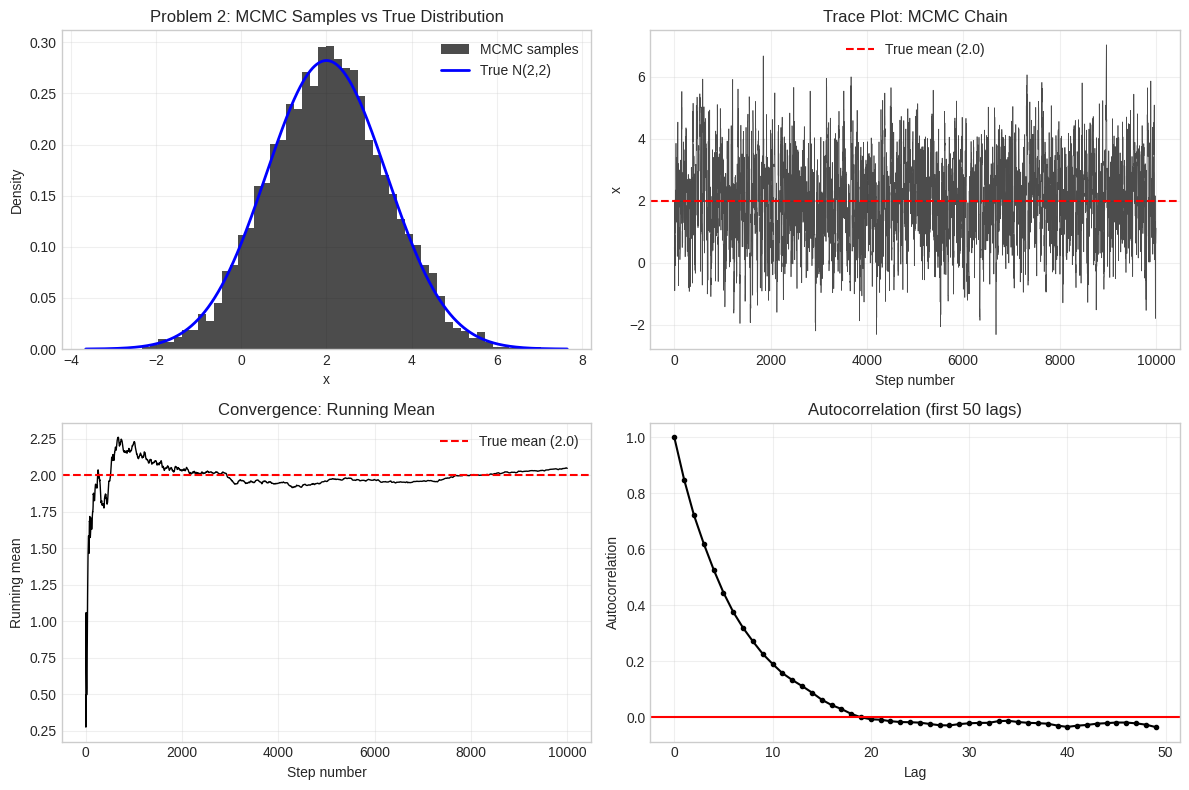

In [34]:
# ===== MAIN PLOT: HISTOGRAM WITH TRUE DENSITY =====
plt.figure(figsize=(12, 8))

# Plot histogram of samples
plt.subplot(2, 2, 1)
n, bins, patches = plt.hist(post_burn_samples, bins=50, density=True,
                           alpha=0.7, color='black', label='MCMC samples')

# Overplot true density
x_range = np.linspace(mu_true - 4*sigma_true, mu_true + 4*sigma_true, 1000)
true_density = target_pdf(x_range)
plt.plot(x_range, true_density, 'b-', linewidth=2, label='True N(2,2)')

plt.xlabel('x')
plt.ylabel('Density')
plt.title('Problem 2: MCMC Samples vs True Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

# ===== TRACE PLOT =====
plt.subplot(2, 2, 2)
plt.plot(samples, 'k-', alpha=0.7, linewidth=0.5)
plt.axhline(y=mu_true, color='r', linestyle='--', label=f'True mean ({mu_true})')
plt.xlabel('Step number')
plt.ylabel('x')
plt.title('Trace Plot: MCMC Chain')
plt.legend()
plt.grid(True, alpha=0.3)

# ===== RUNNING MEAN CONVERGENCE =====
plt.subplot(2, 2, 3)
running_mean = np.cumsum(samples) / (np.arange(n_steps) + 1)
plt.plot(running_mean, 'k-', linewidth=1)
plt.axhline(y=mu_true, color='r', linestyle='--', label=f'True mean ({mu_true})')
plt.xlabel('Step number')
plt.ylabel('Running mean')
plt.title('Convergence: Running Mean')
plt.legend()
plt.grid(True, alpha=0.3)

# ===== AUTOCORRELATION =====
plt.subplot(2, 2, 4)
# Simple autocorrelation estimate
def autocorr(x, lag=100):
    mean = np.mean(x)
    var = np.var(x)
    xp = x - mean
    corr = np.correlate(xp, xp, mode='full')[len(x)-1:] / (var * (len(x) - np.arange(len(x))))
    return corr[:lag]

lags = 50
acf = autocorr(post_burn_samples, lags)
plt.plot(range(lags), acf[:lags], 'ko-', markersize=3)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title(f'Autocorrelation (first {lags} lags)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [35]:
# ===== DIAGNOSTICS AND SUMMARY =====
print("=== CONVERGENCE DIAGNOSTICS ===")

# Gelman-Rubin-like diagnostic (using second half vs first half)
half = len(post_burn_samples) // 2
first_half = post_burn_samples[:half]
second_half = post_burn_samples[half:]

mean_first = np.mean(first_half)
mean_second = np.mean(second_half)
std_first = np.std(first_half)
std_second = np.std(second_half)

print(f"First half mean: {mean_first:.3f}")
print(f"Second half mean: {mean_second:.3f}")
print(f"Difference: {abs(mean_first - mean_second):.3f}")

# Rough integrated autocorrelation time
def integrated_autocorr_time(x, max_lag=100):
    acf = autocorr(x, max_lag)
    return 1 + 2 * np.sum(acf[1:])

tau_est = integrated_autocorr_time(post_burn_samples)
effective_samples = len(post_burn_samples) / tau_est

print(f"Estimated autocorrelation time: {tau_est:.1f}")
print(f"Effective sample size: {effective_samples:.0f}")
print(f"Effective sample rate: {effective_samples/len(post_burn_samples)*100:.1f}%")

=== CONVERGENCE DIAGNOSTICS ===
First half mean: 1.926
Second half mean: 2.132
Difference: 0.205
Estimated autocorrelation time: 8.2
Effective sample size: 1099
Effective sample rate: 12.2%


In [36]:
# ===== COMPARISON WITH EXPECTED RESULTS =====
print("=== COMPARISON WITH PROBLEM STATEMENT EXPECTATIONS ===")
print("The plot should show:")
print("✓ Black histogram matching blue true density curve")
print("✓ Samples centered around x=2")
print("✓ Reasonable spread (std ≈ √2 ≈ 1.414)")
print("✓ Good mixing in trace plot (no getting stuck)")
print("✓ Running mean converging to true mean")
print("✓ Autocorrelation decaying to zero")

# Quantile comparison
true_quantiles = norm.ppf([0.16, 0.5, 0.84], mu_true, sigma_true)
sample_quantiles = np.percentile(post_burn_samples, [16, 50, 84])

print("\nQuantile comparison:")
print(f"True 16%, 50%, 84%: {true_quantiles}")
print(f"Sample 16%, 50%, 84%: {sample_quantiles}")
print(f"Differences: {np.abs(true_quantiles - sample_quantiles)}")

=== COMPARISON WITH PROBLEM STATEMENT EXPECTATIONS ===
The plot should show:
✓ Black histogram matching blue true density curve
✓ Samples centered around x=2
✓ Reasonable spread (std ≈ √2 ≈ 1.414)
✓ Good mixing in trace plot (no getting stuck)
✓ Running mean converging to true mean
✓ Autocorrelation decaying to zero

Quantile comparison:
True 16%, 50%, 84%: [0.59362417 2.         3.40637583]
Sample 16%, 50%, 84%: [0.62669612 2.02093603 3.42680551]
Differences: [0.03307195 0.02093603 0.02042969]
